In [81]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os 

from data_cleanup import *
from feature_selection import *
from model_ import *

from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as rmse
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LassoLarsCV
from sklearn.ensemble import RandomForestRegressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
corr_cols = ['ti_cpi', 'bci_bci', 'ti_cpi_om', 'wbgi_cce']
meta_cols = ['ccode', 'ccode_qog', 'ccodealp', 'ccodealp_year', 'ccodecow', 'cname', 'cname_qog', 'cname_year', 'version', 'year', 'region', 'sub-region']
df = load_reduced_df(corr_cols)

In [83]:
display(df.shape)

(2836, 2528)

### Feature selection

In [84]:
df = drop_date_columns(df)

best_features_dict = {}
selected_features_dict = {}

for target_col in corr_cols:
    X_train, X_test, y_train, y_test = create_traintestsplit(df, corr_cols = corr_cols, meta_cols=meta_cols, target_col=target_col)
    
    best_features = pre_select(X_train, y_train)
    best_features_dict[target_col] = set(best_features)
    df_train = X_train[best_features].copy()
    df_train[target_col]=y_train
    mce = MultiCollinearityEliminator(df_train, target_col, 0.85)
    feaures_no_collinearity = list(mce.autoEliminateMulticollinearity().columns)
    feaures_no_collinearity.remove(target_col)
    selected_features_dict[target_col] = set(feaures_no_collinearity)


#selected_features_dict

In [85]:
best_features_union=list(set.union(*list(best_features_dict.values())))
best_features_intersection=list(set.intersection(*list(best_features_dict.values())))

best_features_intersection

print(df[best_features_union].isna().sum().sort_values(ascending=False))


cpds_vnl_nan         0
cpds_tg_nan          0
wel_sys_1.0          0
cpds_vnl_0.0         0
cpds_govlr_nan       0
ciri_injud_2.0       0
ihme_lifexp_0104f    0
cpds_chg_nan         0
cpds_lper_nan        0
fh_ipolity2          0
ihme_hle_0104f       0
cpds_vper_0.0        0
kun_cluster_5.0      0
br_mon               0
ihme_hle_0104t       0
ihme_lifexp_0104m    0
cpds_vpen_0.0        0
cpds_lpen_nan        0
wel_scalezone_4.0    0
fh_pr_1.0            0
ihme_lifexp_0104t    0
cpds_vpen_nan        0
bmr_demfsuf          0
bmr_dem              0
cpds_chg_0.0         0
gd_ptss_1.0          0
fhp_status5_1.0      0
fh_cl_1.0            0
fh_status_1.0        0
cpds_lall_nan        0
cpds_vper_nan        0
cpds_lall_0.0        0
cpds_lper_0.0        0
cpds_lpen_0.0        0
ihme_hle_0104m       0
dtype: int64


In [86]:
selected_features_union=list(set.union(*list(selected_features_dict.values())))
selected_features_intersection=list(set.intersection(*list(selected_features_dict.values())))

selected_features_intersection

['fh_cl_1.0',
 'cpds_vper_0.0',
 'gd_ptss_1.0',
 'fhp_status5_1.0',
 'fh_status_1.0']

## Modeling

Try Lasso and Random Forest next. Train models for different feature configurations 

    - individual selected features for a particular index
    - union of all good features for all indices
    - intersection of all selected for features for all indices

As scores r2 and rmse are reported. The comparisons are based on r2-scores as they make the scores for different indices comparable.
    

### Lasso
The used library uses cross validation to determine a good value for alpha.

The following script trains for all target indices a Lasso model, then displays r2 score and feature importance information. 

In [87]:
def lasso_info_script(features, name):
    lasso_bf = dict()

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            lasso_bf[target] = apply_lassocv(df, target, list(features[target]), corr_cols, meta_cols, fprint=False)
        else:
            lasso_bf[target] = apply_lassocv(df, target, features, corr_cols, meta_cols, fprint=False)
        df_score.loc[target,] = [lasso_bf[target]['r2'] ,lasso_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    # l_fi = [lasso_bf[target]['feat_importance'] for target in corr_cols]
    # df_fi = pd.concat(l_fi)

    # l_firk = [lasso_bf[target]['feat_importance_rank'] for target in corr_cols]
    # df_firk = pd.concat(l_firk)

    # print('feature importance')
    # display(df_fi)
    # df_fi.T.plot(kind='bar', figsize=(20,8))
    # print()

    # print('feature importance rank')
    # display(df_firk)
    # print()
    # file = os.path.join('pickle', name +'.obj')
    # f = open(file, 'wb')
    # pickle.dump(lasso_bf ,f)
    #f.close()     


First we apply the script for the individually selected features for each corruption index.

In [88]:
lasso_info_script(selected_features_dict, 'lasso_selected_features_dict')

scores


,r2,rmse
ti_cpi,0.627212,9.61274
bci_bci,0.444336,9.774895
ti_cpi_om,0.637547,1.04514
wbgi_cce,0.63687,0.505975


Next we use for all corruption indices the same set of features - the set of all as promising declared features.

In [89]:
lasso_info_script(best_features_union, 'lasso_best_features_union')

scores


,r2,rmse
ti_cpi,0.635061,9.510998
bci_bci,0.455425,9.67687
ti_cpi_om,0.666866,1.001978
wbgi_cce,0.636917,0.505942


In [90]:
df.dtypes[best_features_union]
df.br_mon.describe()

count    2836.000000
mean        0.190056
std         0.392415
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: br_mon, dtype: float64

Now we use only the features that are in all individually selected feature sets.

In [91]:
lasso_info_script(selected_features_intersection, 'lasso_selected_features_intersection')

scores


,r2,rmse
ti_cpi,0.621739,9.683047
bci_bci,0.386012,10.275092
ti_cpi_om,0.63745,1.045281
wbgi_cce,0.650318,0.496517


Findings:

- wbgi_rle (Rule of Law) is by far the most important feature in almost all configurations
- most indices behave similarly for the three feature set configuration but
- ti_cpi is most different: its score is very bad with the smallest feature set. Its most important feature is wbgi_pvs [Political Stability and Absence of Violence/Terrorism, Standard error] and not wbgi_rle
- vdem_jucorrdc is also effected more by different feature sets and its score is lower as well in general.
- all the other indices gain information slightly by more features but they do not rely too much on the chosen setups

### Random Forest

Next we do the same for a Random Forest Regressor. Here initially no cross validation is done. We just use a default setup at first.

In [92]:
def rf_info_script(features, name):
    rf_bf = dict()

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            rf_bf[target] = apply_rf(df, target, list(features[target]), corr_cols, meta_cols, fprint=False)
        else:
            rf_bf[target] = apply_rf(df, target, features, corr_cols, meta_cols, fprint=False)
        df_score.loc[target,] = [rf_bf[target]['r2'] ,rf_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    # l_fi = [rf_bf[target]['feat_importance'] for target in corr_cols]
    # df_fi = pd.concat(l_fi)

    # l_firk = [rf_bf[target]['feat_importance_rank'] for target in corr_cols]
    # df_firk = pd.concat(l_firk)

    # print('feature importance')
    # display(df_fi)

    # df_fi.T.plot(kind='bar', figsize=(20,8))
    # print()

    # print('feature importance rank')
    # display(df_firk)
    # print()
    # file = os.path.join('pickle', name +'.obj')
    # f = open(file, 'wb')
    # pickle.dump(rf_bf ,f)
    #f.close()    



First we apply again the script for the individually selected features for each corruption index.

In [93]:
rf_info_script(selected_features_dict, 'rf_selected_features_dict')

scores


,r2,rmse
ti_cpi,0.600142,9.955629
bci_bci,0.332477,10.713687
ti_cpi_om,0.675702,0.988601
wbgi_cce,0.5315,0.574715


Next we use for all corruption indices the same set of features - the set of all as promising declared features.

In [94]:
rf_info_script(best_features_union, 'rf_best_features_union')

scores


,r2,rmse
ti_cpi,0.639009,9.459415
bci_bci,0.426724,9.928597
ti_cpi_om,0.677534,0.985805
wbgi_cce,0.640286,0.503589


Now we use only the features that are in all individually selected feature sets.

In [95]:
rf_info_script(selected_features_intersection, 'rf_best_features_union')

scores


,r2,rmse
ti_cpi,0.593483,10.038187
bci_bci,0.363788,10.459399
ti_cpi_om,0.606302,1.089257
wbgi_cce,0.627294,0.512602


The general picture of the results with Random Forest is not that different to the one with Lasso. Some differences are

- ti_cpi is predicted very well now both in comparison with Lasso and with all other indices
- HOWEVER, if only the minimal feature set is used ti_cpi is even worse than with Lasso
- for vdem_execorr the vdem_egal (Egalitarian component index) is the most important feature
- vdem_jucorr is now by far the most difficult to predict index
- although feature importance is not straight-forward comparable between Lasso (weight of coefficients) and Random Forest (Gini) it seems like Random Forst discriminates harder with regard to features

Random Forest performs either similarly or better for most setups / indices allthough no parameter optimization is done by now. So we continue with Random Forst and do hyperparameter optimization for some specific settings next to further optimize the results.

### Grid Search: Random Forest

With cross validation / hyperparameter grid search better parameters are determined. With those optimizations then again models are trained, then the test set is predicted and scores are evaluated.

The script defined below shows a similar report than above.

In [96]:
def rf_gridsearch_info_script(features, name):
    rf_bf = dict()

    param_grid = {
        "randomforestregressor__max_depth": [2, 3, 5, 10, None],
        "randomforestregressor__min_samples_split": [2, 3, 5, 10],
        "randomforestregressor__max_features": ["log2", None]
        }

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            rf_bf[target] = apply_gridsearch_rf(df, target, list(features[target]), param_grid, corr_cols, meta_cols, fprint=False)
        else:
            rf_bf[target] = apply_gridsearch_rf(df, target, features, param_grid, corr_cols, meta_cols, fprint=False)
        df_score.loc[target,] = [rf_bf[target]['r2'] ,rf_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    # l_fi = [rf_bf[target]['feat_importance'] for target in corr_cols]
    # df_fi = pd.concat(l_fi)
    # rf_bf[target]
    # l_firk = [rf_bf[target]['feat_importance_rank'] for target in corr_cols]
    # df_firk = pd.concat(l_firk)
    # rf_bf[target]['params']
    # l_params = [rf_bf[target]['params'] for target in corr_cols]
    # df_params = pd.concat(l_params)

    # print('feature importance')
    # display(df_fi)

    # df_fi.T.plot(kind='bar', figsize=(20,8))
    # print()

    # print('feature importance rank')
    # display(df_firk)
    
    # file = os.path.join('pickle', name +'.obj')
    # f = open(file, 'wb')
    # pickle.dump(rf_bf ,f)
    #f.close()    



Now we only use for each index the individually selected feature set as we saw above that the results are comparable (so the feature selection process works adequately).

In [97]:
rf_gridsearch_info_script(selected_features_dict, 'rf_grid_selected_features_dict')

scores


,r2,rmse
ti_cpi,0.729854,8.183054
bci_bci,0.546616,8.829555
ti_cpi_om,0.740563,0.884229
wbgi_cce,0.694517,0.464078


For most indices the hyperparameter optimization does not seem to significantly improve the r2-scores. But for vdem_jucorrdc it seems to improve. For vdem_pubcorr and wbgi_cce the improvement is minor.

The feature importance (figure) changes a lot more. Here we see for all but bci_bci that relatively wbgi_rle is not as important anymore. This is most likely due to the max_samples_features being log2 now. One could argue if the original model where wbgi_rle is the main feature is simpler and from the same quality or on the other side that other features are also able to replace wbgi_rle when combined.

In [98]:
rf_bf = rf_gridsearch_info_script(selected_features_union, 'rf_grid_selected_features_union')

scores


,r2,rmse
ti_cpi,0.703997,8.565723
bci_bci,0.530455,8.98555
ti_cpi_om,0.768536,0.8352
wbgi_cce,0.732704,0.434104


feature importance


,ciri_injud_2.0,wel_scalezone_4.0,ihme_lifexp_0104t,cpds_chg_0.0,gd_ptss_1.0,fhp_status5_1.0,fh_pr_1.0,fh_status_1.0,cpds_lall_0.0,fh_cl_1.0,cpds_vper_0.0,kun_cluster_5.0,br_mon,fh_ipolity2,wel_sys_1.0,ihme_lifexp_0104m
ti_cpi,0.0,0.0,0.15334,0.004825,0.052266,0.011238,0.165528,0.045034,0.039381,0.143951,0.031202,0.0,0.056827,0.150349,0.001345,0.144713
bci_bci,0.013009,0.004152,0.14338,0.001811,0.073026,0.0103,0.135026,0.005359,0.014911,0.112582,0.037757,0.025395,0.088233,0.180035,0.014296,0.140729
ti_cpi_om,0.026002,0.002294,0.117366,0.000488,0.017618,0.002103,0.184292,0.005171,0.030968,0.109597,0.044404,0.08605,0.038964,0.155704,0.102907,0.076071
wbgi_cce,0.00888,0.001526,0.126047,0.000182,0.046181,0.009161,0.254158,0.014801,0.043426,0.112754,0.085673,0.020112,0.03532,0.163803,0.010699,0.067278


,fh_pr_1.0,fh_ipolity2,ihme_lifexp_0104t,fh_cl_1.0,ihme_lifexp_0104m,br_mon,cpds_vper_0.0,gd_ptss_1.0,kun_cluster_5.0,wel_sys_1.0,cpds_lall_0.0,fh_status_1.0,ciri_injud_2.0,fhp_status5_1.0,wel_scalezone_4.0,cpds_chg_0.0
ti_cpi,0.165528,0.150349,0.15334,0.143951,0.144713,0.056827,0.031202,0.052266,0.0,0.001345,0.039381,0.045034,0.0,0.011238,0.0,0.004825
bci_bci,0.135026,0.180035,0.14338,0.112582,0.140729,0.088233,0.037757,0.073026,0.025395,0.014296,0.014911,0.005359,0.013009,0.0103,0.004152,0.001811
ti_cpi_om,0.184292,0.155704,0.117366,0.109597,0.076071,0.038964,0.044404,0.017618,0.08605,0.102907,0.030968,0.005171,0.026002,0.002103,0.002294,0.000488
wbgi_cce,0.254158,0.163803,0.126047,0.112754,0.067278,0.03532,0.085673,0.046181,0.020112,0.010699,0.043426,0.014801,0.00888,0.009161,0.001526,0.000182



feature importance rank


,ciri_injud_2.0,wel_scalezone_4.0,ihme_lifexp_0104t,cpds_chg_0.0,gd_ptss_1.0,fhp_status5_1.0,fh_pr_1.0,fh_status_1.0,cpds_lall_0.0,fh_cl_1.0,cpds_vper_0.0,kun_cluster_5.0,br_mon,fh_ipolity2,wel_sys_1.0,ihme_lifexp_0104m
ti_cpi,<NA>,<NA>,2,12,7,11,1,8,9,5,10,<NA>,6,3,13,4
bci_bci,12,15,2,16,7,13,4,14,10,5,8,9,6,1,11,3
ti_cpi_om,11,14,3,16,12,15,1,13,10,4,8,6,9,2,5,7
wbgi_cce,14,15,3,16,7,13,1,11,8,4,5,10,9,2,12,6



Index(['fh_pr_1.0', 'fh_ipolity2', 'ihme_lifexp_0104t', 'fh_cl_1.0',
       'ihme_lifexp_0104m', 'br_mon', 'cpds_vper_0.0', 'gd_ptss_1.0',
       'kun_cluster_5.0', 'wel_sys_1.0', 'cpds_lall_0.0', 'fh_status_1.0',
       'ciri_injud_2.0', 'fhp_status5_1.0', 'wel_scalezone_4.0',
       'cpds_chg_0.0'],
      dtype='object')


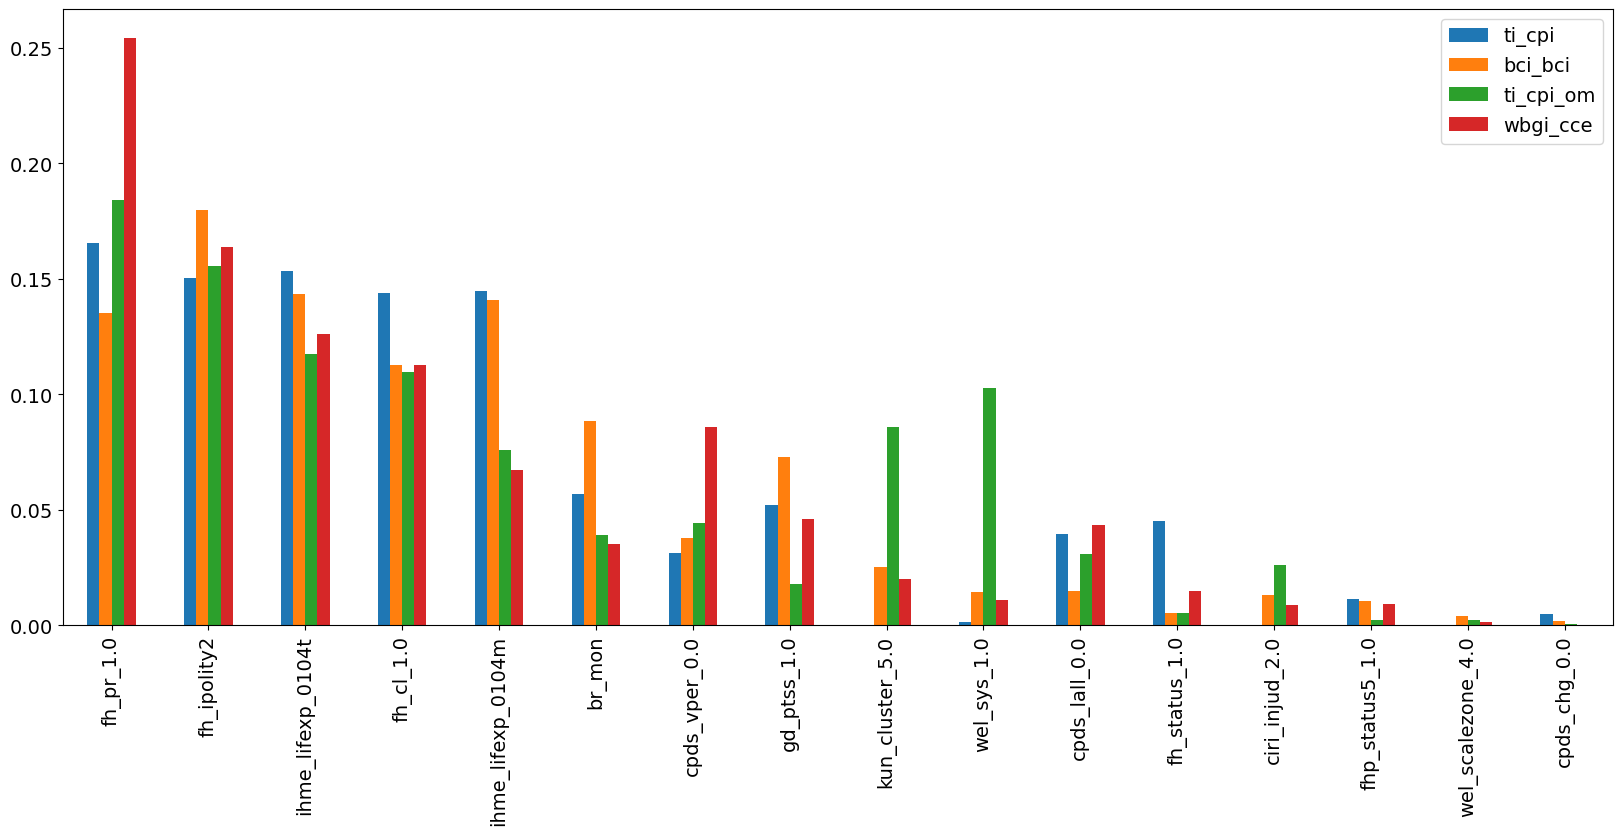

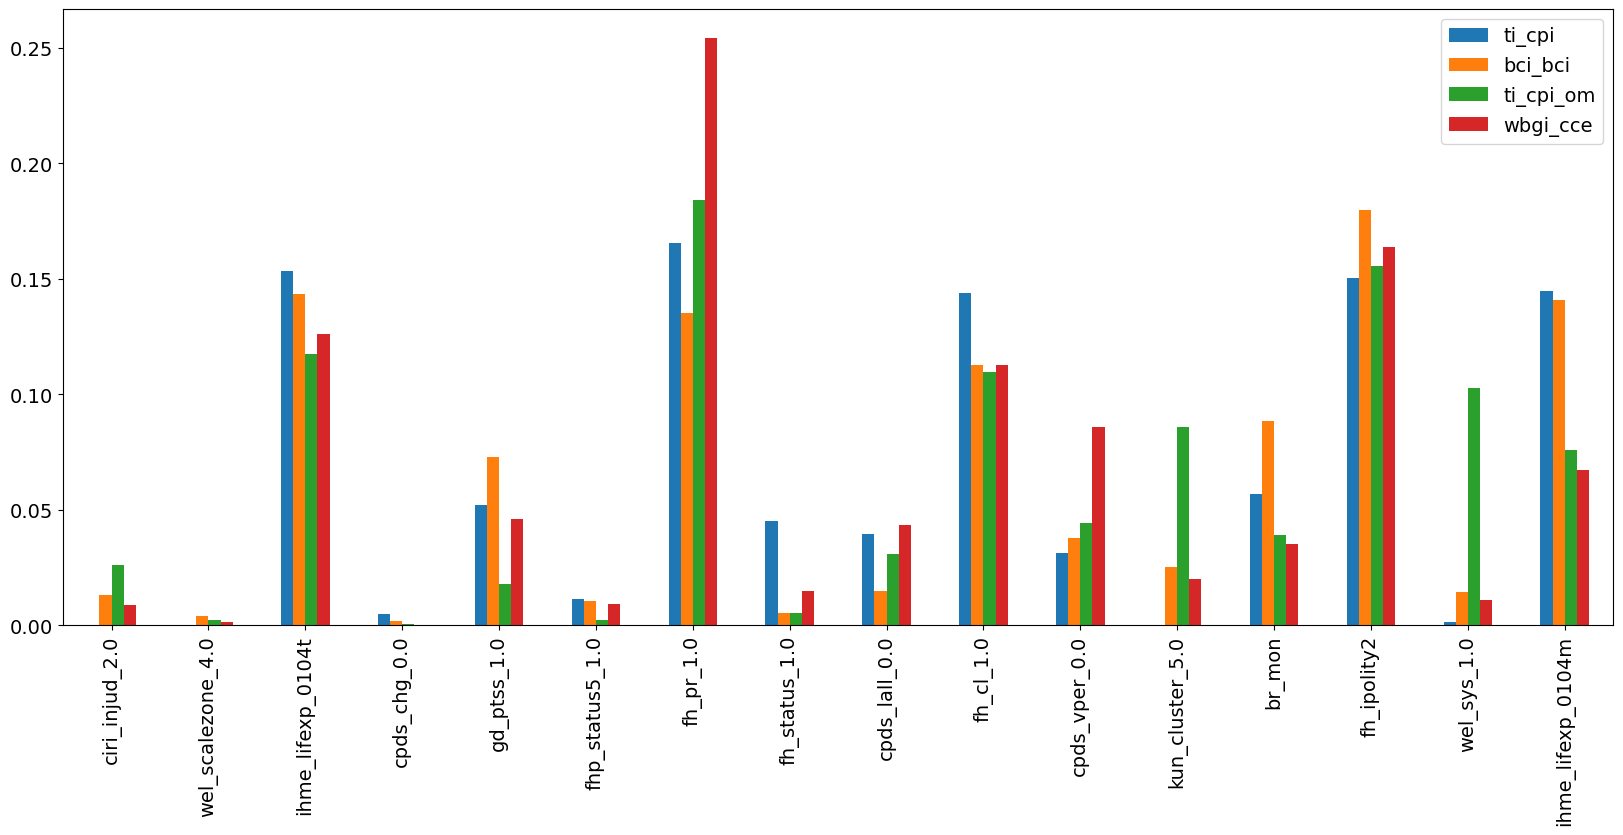

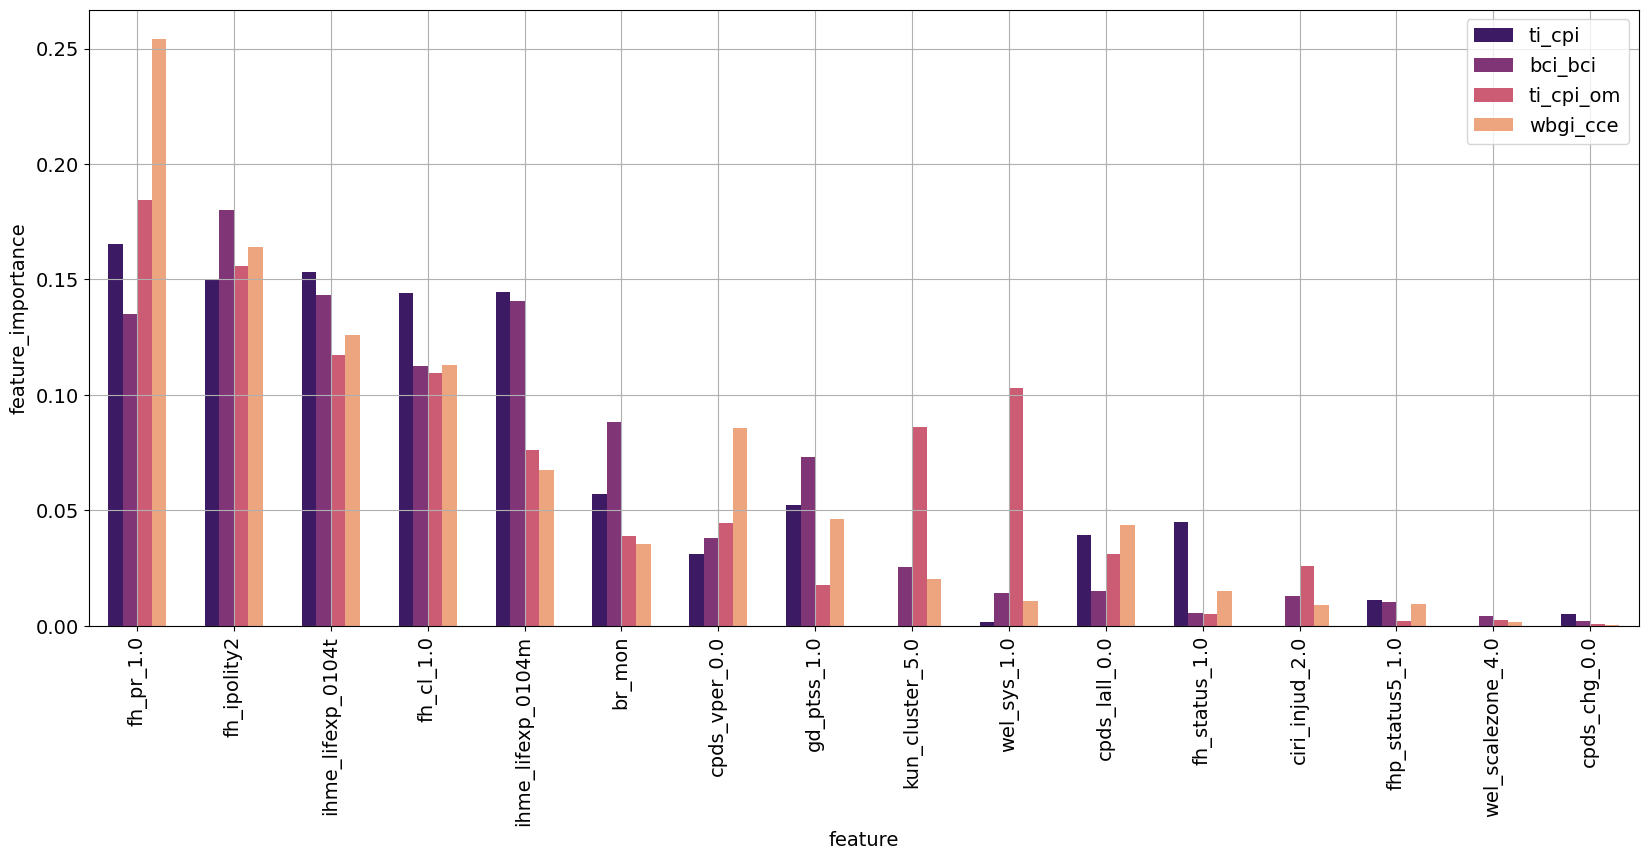

In [99]:

f = open('pickle/rf_grid_selected_features_union.obj', 'rb')
rf_bf = pickle.load(f)
f.close()

l_fi = [rf_bf[target]['feat_importance'] for target in corr_cols]
df_fi = pd.concat(l_fi)
l_firk = [rf_bf[target]['feat_importance_rank'] for target in corr_cols]
df_firk = pd.concat(l_firk)
l_params = [rf_bf[target]['params'] for target in corr_cols]
df_params = pd.concat(l_params)

print('feature importance')
display(df_fi)


df_sorted = df_fi.reindex(df_fi.mean().sort_values().index[::-1], axis=1)

display(df_sorted)
df_sorted.T.plot(kind='bar', figsize=(20,8))

df_fi.T.plot(kind='bar', figsize=(20,8))
print()

print('feature importance rank')
display(df_firk)
print()
print(df_sorted.columns)




df_fi = df_fi.reindex(df_fi.mean().sort_values(ascending=False).index, axis=1)
col_names = df_fi.columns
df_fi = df_fi.T.melt(
    ignore_index=False,
    value_vars = ['ti_cpi', 'bci_bci', 'ti_cpi_om', 'wbgi_cce'],
    value_name = 'feature_importance'
).reset_index().rename(columns={'index': 'feature', 'variable': 'corruption_index'})

plt.rcdefaults()
font = {'family' : 'normal',
    'size'   : 14}

plt.rc('font', **font)
plt.figure(figsize=(20,8))
sns.barplot(df_fi, x='feature',  y='feature_importance', hue='corruption_index', palette='magma', width=0.6)
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.grid()